# Project 4
Student name: Zhiqiang Sun

Student pace: self paced

## Business understanding
The skin cancer dataset contains many medical images that show various kinds of skin cancer. In this project, we will analyze and visualize the relationship between cancer and age and the location of the body. Furthermore, we will use machine learning to train a model that can distinguish the cancer type by given images. 

## Dataset
The whole dataset were download from kaggle (https://www.kaggle.com/code/rakshitacharya/skin-cancer-data/data). The folder contains several csv files and two images folder. All the name of images were named with image id which can be found in the metadata excel file. There are several other hinist csv file which include the pixels information of corresponding images in different resolusion. In this project, we will focus on the information from the metadata. Also, when we creat the model, we will use the original images for higher resolusion, thus we will dismiss all the hmnist data this time. 

The data has seven different classes of skin cancer which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

In this project, I will try to train a model of 7 different skin cancer classes using Convolution Neural Network with Keras TensorFlow and then use it to predict the types of skin cancer with random images.
Here is the plan of the project step by step:



1. Import all the necessary libraries for this project
2. Make a dictionary of images and labels
3. Reading and processing the metadata
4. Process data cleaning
5. Exploring the data analysis
6. Train Test Split based on the data frame 
7. Creat and transfer the images to the corresponding folders 
8. Do image augmentation and generate extra images to the imbalanced skin types
9. Do data generator for training, validation, and test folders
10. Build the CNN model
11. Fitting the model
12. Model Evaluation
13. Visualize some random images with prediction


## 1. Import all the necessary libraries for this project

In [2]:
# import all the necessary library for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, inception_resnet_v2, xception
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

## Make a dictionary of images and labels
In this steps, I make the path for all the images and a dictionary for all types of skin cancers with full names.

In [3]:
path_dict = {os.path.splitext(os.path.basename(x))[0] :x for  x in glob(os.path.join('*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


## 3. Reading and processing the metadata
In this step, we have read the csv which had the information for all the patients and images. Afterthat, we made three more columns including the cancer type in full name, the label in skin cancers in digital and the path of image_id in the folder.

In [4]:
# read the metadata
meta = pd.read_csv('HAM10000_metadata.csv')
print(meta.shape)
meta.head()


(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# generate new columns of type, lebel and path
meta['type'] = meta['dx'].map(lesion_type_dict.get)
meta['label'] = pd.Categorical(meta['type']).codes
meta['path'] = meta['image_id'].map(path_dict.get)

In [6]:
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,type,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg


## 4. Process data cleaning
In this part, we check the missing values for each column and fill them. 

In [7]:
meta.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
type             0
label            0
path             0
dtype: int64

There are 57 null values in the columns of age. We then fill them with the mean.

In [8]:
# fill the missing age with their mean.
meta['age'].fillna((meta['age'].mean()), inplace=True)

In [9]:
meta.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
type            0
label           0
path            0
dtype: int64

## 5. Exploring the data analysis

In this part, we briefly explored different features of the dataset, their distributions and counts.

As there is some duplecate lesion_id which belong to same patient, all the features except the image_id for them are same with each other.  Thus, we first find and remove the duplex. 

In [10]:
# compare the unique values for lesion id and image id.
meta.lesion_id.nunique(), meta.image_id.nunique()


(7470, 10015)

In [11]:
# drop the duplication based on the lesion_id.
meta_patient = meta.drop_duplicates(subset=['lesion_id'])

In [12]:
meta_patient.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,type,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0029176.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025837.jpg


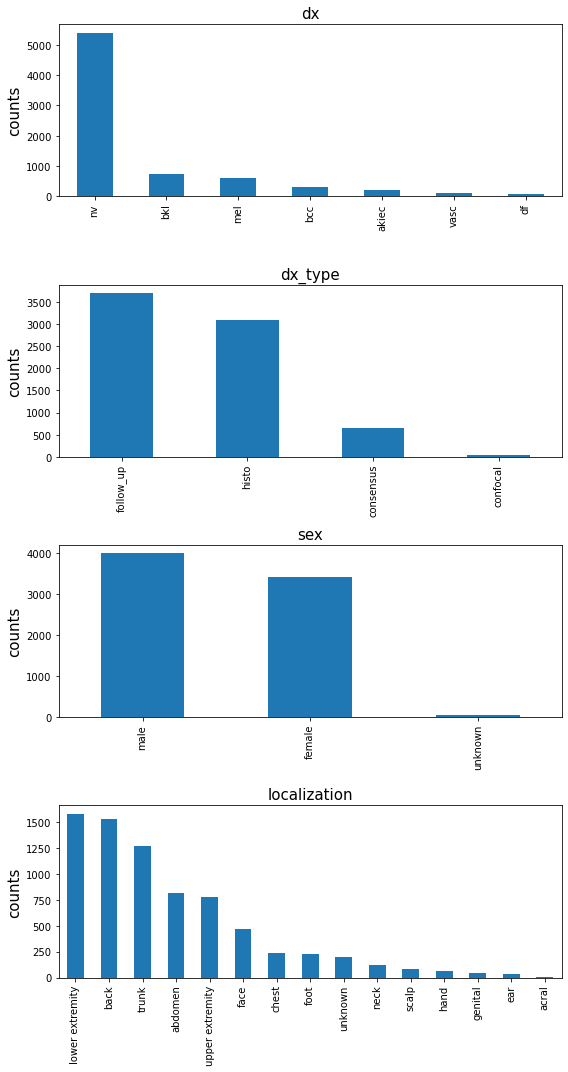

In [13]:
# plot distribution of features 'dx', 'dx_type',  'sex', 'localization'.
feat = ['dx', 'dx_type',  'sex', 'localization']
plt.subplots(figsize=(8, 15))
for i, fea in enumerate(feat):
    length = len(feat)
    plt.subplot(4, 1, i+1)
    meta_patient[fea].value_counts().plot.bar(fontsize = 10)
    plt.ylabel('counts', fontsize = 15)
    plt.xticks()
    plt.title(fea, fontsize = 15)
    plt.tight_layout()

We checked the distribution of columns 'dx', 'dx_type',  'sex', 'localization' for different patients. The graphs show that:
1. In dx features, the 'nv': 'Melanocytic nevi' case take more than 70% of the total cases. The number suggests that this dataset is an unbalanced dataset.
2. In dx_type features, the histogram suggests most of the cancer were confirmed in Follow-up and histo Histopathologic diagnoses.
3. The sex feature shows that the amount of male who had skin cancer is slight larger than female but still similar to each other.
4. The localization analysis shows that  lower extremity, back ,trunk abdomen and upper extremity are heavily compromised regions of skin cancer

In [14]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html 
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output
app = JupyterDash(__name__)
server = app.server


In [19]:


app.layout = html.Div(children=[
    html.H1(children='Distribution of Age', style={'text-align': 'center'}),
    

    html.Div([
        html.Label(['Choose a graph:'],style={'font-weight': 'bold'}),
        dcc.Dropdown(
            id='dropdown',
            options=[
                {'label': 'all types', 'value': 'all'},
                {'label': 'nv', 'value': 'nv'},
                {'label': 'bkl', 'value': 'bkl'},
                {'label': 'mel', 'value': 'mel'},
                {'label': 'bcc', 'value': 'bcc'},
                {'label': 'akiec', 'value': 'akiec'},
                {'label': 'vasc', 'value': 'vasc'},
                {'label': 'df', 'value': 'df'}
                    ],
            value='all types',
            style={"width": "60%"}),
        
    html.Div(dcc.Graph(id='graph')),        
        ]),

])

@app.callback(
    Output('graph', 'figure'),
    [Input(component_id='dropdown', component_property='value')]
)
def select_graph(value):
    if value == 'all':
        fig = px.histogram(None , x= meta_patient['age'], nbins=20, labels={'x':value, 'y':'count'})
    
        return fig
    else:
        fig = px.histogram(None , x= meta_patient[meta_patient['dx'] == value]['age'], 
                           nbins=20,  labels={'x':value, 'y':'count'})
    
        return fig



In [21]:
if __name__ == '__main__':
    app.run_server()

Dash app running on http://127.0.0.1:8050/


In [20]:
if __name__ == '__main__':
    app.run_server(mode = 'inline')

In general, most cancers happen between 35 to 70.  Age 45 is a high peak for patients to get a skin cancer.  Some types of skin cancer (vasc, nv) happen to those below 20, and others occur most after 30.

## 6. Train Test Split based on the data frame 
We split the dataset to training (70%), validation (10%) and testing (20%) by train_test_split.

In [24]:
df = meta.drop(columns='label')
target = meta['label']
X_train_a, X_test, y_train_a, y_test = train_test_split(df, target, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_a, y_train_a, test_size=0.1, random_state=12)

In [25]:
X_train.shape, X_val.shape, X_test.shape

((7210, 9), (802, 9), (2003, 9))

## 7. Creat and transfer the images to the corresponding folders 
We created the subfolders containing the train, Val, and test folder. In addition, we created a folder for all types of skin cancers in each of the folders. Finally, We transferred the images to the corresponding folder based on the data frame and the path in each image ID.

In [26]:
# copy the images to correct folder according to the image_id in dataframe

new_dir = 'sub_folders2'
os.makedirs(new_dir)  # creat the subfolders
TVT = ['train', 'val', 'test']
lesion = lesion_type_dict.keys()
for first in TVT:
    temp_dir = os.path.join(new_dir, first)
    os.mkdir(temp_dir) # creat the train, val and test folders

    for sec in lesion:
        sec_dir = os.path.join(temp_dir, sec)
        os.mkdir(sec_dir) # creat the subfolders of all tpyes of cancers
        
        if first == 'train':
            source_df = X_train[X_train['dx'] == sec] # find the source of train dataset
        if first == 'val':
            source_df = X_val[X_val['dx'] == sec] # find the source of validation dataset
        elif first == 'test':
            source_df = X_test[X_test['dx'] == sec] # find the source of test dataset

        
        for source in source_df.path: # find the images to transfer
            shutil.copy(source, sec_dir)
        print("{} files copied to {}".format(len(source_df.path), sec_dir))
        
    
    

4846 files copied to sub_folders2\train\nv
782 files copied to sub_folders2\train\mel
783 files copied to sub_folders2\train\bkl
378 files copied to sub_folders2\train\bcc
241 files copied to sub_folders2\train\akiec
101 files copied to sub_folders2\train\vasc
79 files copied to sub_folders2\train\df
539 files copied to sub_folders2\val\nv
91 files copied to sub_folders2\val\mel
91 files copied to sub_folders2\val\bkl
36 files copied to sub_folders2\val\bcc
22 files copied to sub_folders2\val\akiec
11 files copied to sub_folders2\val\vasc
12 files copied to sub_folders2\val\df
1320 files copied to sub_folders2\test\nv
240 files copied to sub_folders2\test\mel
225 files copied to sub_folders2\test\bkl
100 files copied to sub_folders2\test\bcc
64 files copied to sub_folders2\test\akiec
30 files copied to sub_folders2\test\vasc
24 files copied to sub_folders2\test\df


## 8. Do image augmentation and generate extra images to the imbalanced skin types
The amounts of files in each training folder type tell us the images of nv are much higher than others. The imbalance of the training dataset might cause a high bias in model fitting. Thus we will generate some more images for other kinds of cancers. Here we use image augmentation to oversample the samples in all classes except nv. Here is a simple chart about the oversampling.

![title](images/oversampling.png)

In [27]:
# We only need to fill more images to all class except nv
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for cat in class_list:
    # creat temp folder for augmentaion
    temp_dir = 'temp'
    os.mkdir(temp_dir)
    img_dir = os.path.join(temp_dir, cat)
    os.mkdir(img_dir) 
    
    # copy the original images to temperate folder
    img_list = os.listdir('sub_folders2/train/'+cat)
     
    for image in img_list:
        source = os.path.join('sub_folders2/train/'+cat, image)
        dest = os.path.join(temp_dir)
        shutil.copy(source,img_dir)
    
    path = temp_dir
    save_path = 'sub_folders2/train/'+cat
    # set the parameters of image augmentation
    data_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
                                       width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
                                       height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                                       shear_range=0.2,# Randomly shear image 
                                       zoom_range=0.2, # Randomly zoom image 
                                       horizontal_flip=True, # randomly flip images
                                       vertical_flip=True,# randomly flip images
                                       fill_mode='nearest')

    
    batch_size = 50
    
    temp_generator = data_datagen.flow_from_directory(path,
                                                      save_to_dir = save_path,
                                                      save_format = 'jpg',
                                                      target_size = (224, 224),
                                                      batch_size=batch_size
                                                        )
    # Generate the temp images and add them to the training folders
    
    num_needed = 5000 
    num_cur =  len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_needed - num_cur)/batch_size))
    
    for i in range (0, num_batches):
        imgs, label = next(temp_generator)
    # delete the temp folders after each transfer
    shutil.rmtree(temp_dir)

Found 782 images belonging to 1 classes.
Found 783 images belonging to 1 classes.
Found 378 images belonging to 1 classes.
Found 241 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 79 images belonging to 1 classes.


In [30]:
int(np.ceil((5000 - 101)/batch_size))

98

In [28]:
# check the files in each of the folders after image augmentation
class_list = ['nv', 'mel','bkl','bcc','akiec','vasc','df']

for cat in class_list:
    print(len(os.listdir('sub_folders/train/'+cat)))

4846
4942
4948
4786
4870
3433
4000


The numers of files in each folders are in same levels.

## 9. Do data generator for training, validation, and test folders


In [31]:
new_dir = 'sub_folders2/'
train_dir = '{}train'.format(new_dir)
validation_dir = '{}val/'.format(new_dir)
test_dir = '{}test/'.format(new_dir)

batch_size = 50
image_size = 224

data_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=180 ,# randomly rotate images in the range (degrees, 0 to 40)
                                   width_shift_range=0.2,# randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.2,# randomly shift images vertically (fraction of total height)
                                   shear_range=0.2,
                                   zoom_range=0.2, # Randomly zoom image 
                                   horizontal_flip=True, # randomly flip images
                                   vertical_flip=True, # randomly flip images
                                   fill_mode='nearest')


train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, 
                                                    target_size=(image_size, image_size), 
                                                    batch_size= batch_size,
                                                    class_mode='categorical') 


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, 
                                                target_size=(image_size, image_size), 
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, 
                                                target_size=(image_size, image_size), 
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)




Found 31825 images belonging to 7 classes.
Found 802 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


## 10. Build the CNN model
WE build a CNN model base on the pretrained model 'xception'.

In [32]:
cnn_base_xception = xception.Xception(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base_xception)
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))  # dropout 25% of the nodes to prevent overfitting
model.add(layers.Dense(7, activation='softmax'))

cnn_base_xception.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 33,707,567
Trainable params: 12,846,087
Non-trainable params: 20,861,480
_________________________________________________________________


## 11. Fitting the model
We fit the training data to the model we created earlier

In [33]:
# find out the numbers of trainning and validation
num_train = len(train_generator.labels)
num_val = len(val_generator.labels)
train_steps = np.ceil(num_train/batch_size)
val_steps = np.ceil(num_val/batch_size)


In [34]:
# compile and fit the model with training dataset
model.compile(loss='categorical_crossentropy',
               # set the optimizer
              optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['acc'])

history = model.fit(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=val_steps)

Epoch 1/20
637/637 [==============================] - 1554s 2s/step - loss: 1.6519 - acc: 0.3989 - val_loss: 0.9135 - val_acc: 0.6596
Epoch 2/20
637/637 [==============================] - 1581s 2s/step - loss: 1.2000 - acc: 0.5176 - val_loss: 0.8770 - val_acc: 0.7182
Epoch 3/20
637/637 [==============================] - 1440s 2s/step - loss: 1.0849 - acc: 0.5607 - val_loss: 0.8561 - val_acc: 0.7257
Epoch 4/20
637/637 [==============================] - 1549s 2s/step - loss: 1.0083 - acc: 0.5846 - val_loss: 0.8653 - val_acc: 0.7207
Epoch 5/20
637/637 [==============================] - 1520s 2s/step - loss: 0.9474 - acc: 0.6095 - val_loss: 0.8313 - val_acc: 0.7282
Epoch 6/20
637/637 [==============================] - 1548s 2s/step - loss: 0.8930 - acc: 0.6325 - val_loss: 0.8380 - val_acc: 0.7095
Epoch 7/20
637/637 [==============================] - 1429s 2s/step - loss: 0.8470 - acc: 0.6491 - val_loss: 0.9815 - val_acc: 0.7469
Epoch 8/20
637/637 [==============================] - 1427s 2s

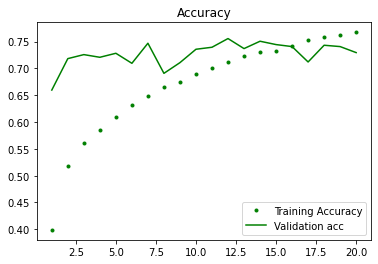

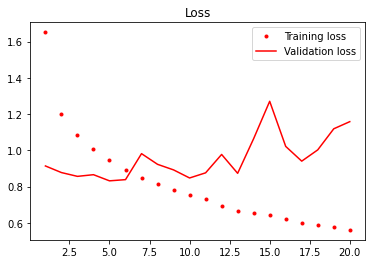

In [35]:
# Plot the accuracy and loss for train and validation. 
def plot_acc(history):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
plot_acc(history)

In [ ]:
#save the model
model.save('results_on_xception_final_2.h5')

## 12. Model Evaluation
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [37]:
# evaluate the model with test dataset.
test_loss, test_acc = model.evaluate(test_generator, steps=2003)

2003/2003 [==============================] - 166s 82ms/step - loss: 1.0831 - acc: 0.7484


The accuracy of the model is 74.84% which is not bad at all.

In [39]:
# generate the prediction and true value of y
Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = test_generator.labels

In [40]:
# make teh confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
confusion_mtx

array([[  21,    3,   16,    1,   15,    8,    0],
       [   7,   42,   21,    2,   13,    8,    7],
       [   4,    6,  111,    1,   52,   51,    0],
       [   0,    4,    0,    6,    6,    8,    0],
       [   3,    4,   30,    3,  115,   82,    3],
       [   2,    6,   31,    0,   91, 1189,    1],
       [   1,    1,    0,    0,    1,   12,   15]], dtype=int64)

In [41]:
indices = test_generator.class_indices

In [42]:
indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [155]:
indices.keys()

dict_keys(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])

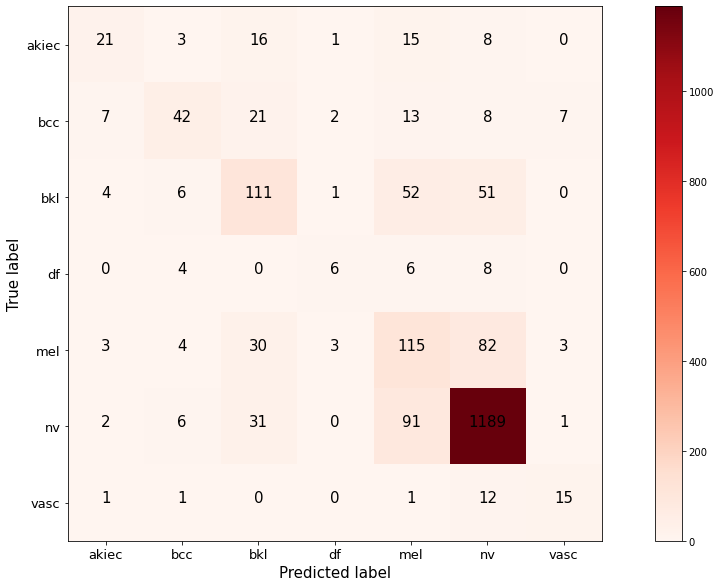

In [43]:
# plot the confusion matrix
plt.figure(figsize=(15,8))
def plot_confusion_matrix(mtx, indices, normalize = False, title = 'confusion matrix', cmap = plt.cm.Reds):
    plt.imshow(mtx, interpolation='nearest', cmap = cmap)
    plt.title = title
    plt.colorbar()
    tick_mark = np.arange(len(indices))
    plt.xticks (tick_mark, indices.keys(),  fontsize = 13)
    plt.yticks (tick_mark, indices.keys(), fontsize = 13)
    
    if normalize:
        mtx = mtx/mtx.sum(axis = 1)[:,np.newaxis]
    
    
    for i in range(mtx.shape[0]):
        for j in range(mtx.shape[1]):
            plt.text(j,i,mtx[i][j], horizontalalignment = 'center', fontsize = 15)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)
    
plot_confusion_matrix(confusion_mtx, indices = indices)    

In [44]:
print(classification_report(Y_true,Y_pred_classes,target_names =['akiec', 'bcc', 'bkl','df', 'mel', 'nv','vasc' ]))

              precision    recall  f1-score   support

       akiec       0.55      0.33      0.41        64
         bcc       0.64      0.42      0.51       100
         bkl       0.53      0.49      0.51       225
          df       0.46      0.25      0.32        24
         mel       0.39      0.48      0.43       240
          nv       0.88      0.90      0.89      1320
        vasc       0.58      0.50      0.54        30

    accuracy                           0.75      2003
   macro avg       0.58      0.48      0.52      2003
weighted avg       0.75      0.75      0.74      2003



The f1 score for nv class is highest and over 0.88. The f1-score on df, akiec and mel are less than 0.5 which sugessted that the prediction on these three type are less accurate. 

Text(0, 0.5, 'Fraction classified incorrectly')

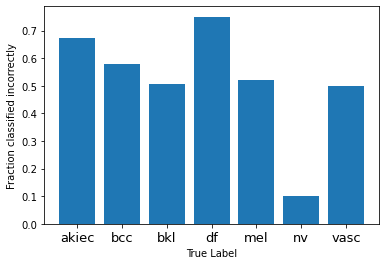

In [45]:
# plot the mistypes of prediction for every class
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
tick_mark = np.arange(len(indices))
plt.xticks (tick_mark, indices.keys(),  fontsize = 13)
plt.ylabel('Fraction classified incorrectly')

It seems that the maximum number of incorrect predicitons are features mel and then df and akiec. The nv has least misclassified type. 

In [161]:
Y_pred

array([[3.7437526e-03, 1.3480504e-04, 3.8490746e-02, ..., 2.8613865e-02,
        9.2899394e-01, 1.0101636e-05],
       [2.0039896e-02, 6.7354552e-03, 1.7757699e-02, ..., 1.0783712e-01,
        8.4751672e-01, 2.5342695e-06],
       [3.2601748e-02, 3.6140077e-02, 2.0308127e-01, ..., 2.0343044e-01,
        5.0982726e-01, 1.8069515e-03],
       ...,
       [3.9168463e-05, 1.9720089e-04, 3.9278907e-03, ..., 2.4453306e-03,
        2.4401614e-01, 7.4937022e-01],
       [3.1192115e-04, 2.1791497e-04, 9.5103048e-03, ..., 2.3532719e-03,
        9.8609805e-01, 1.4999604e-03],
       [5.2359872e-03, 6.1918255e-02, 4.2256869e-02, ..., 2.9939755e-03,
        1.7306456e-02, 8.7008637e-01]], dtype=float32)

In [48]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

(2003, 224, 224, 3)
(2003, 7)


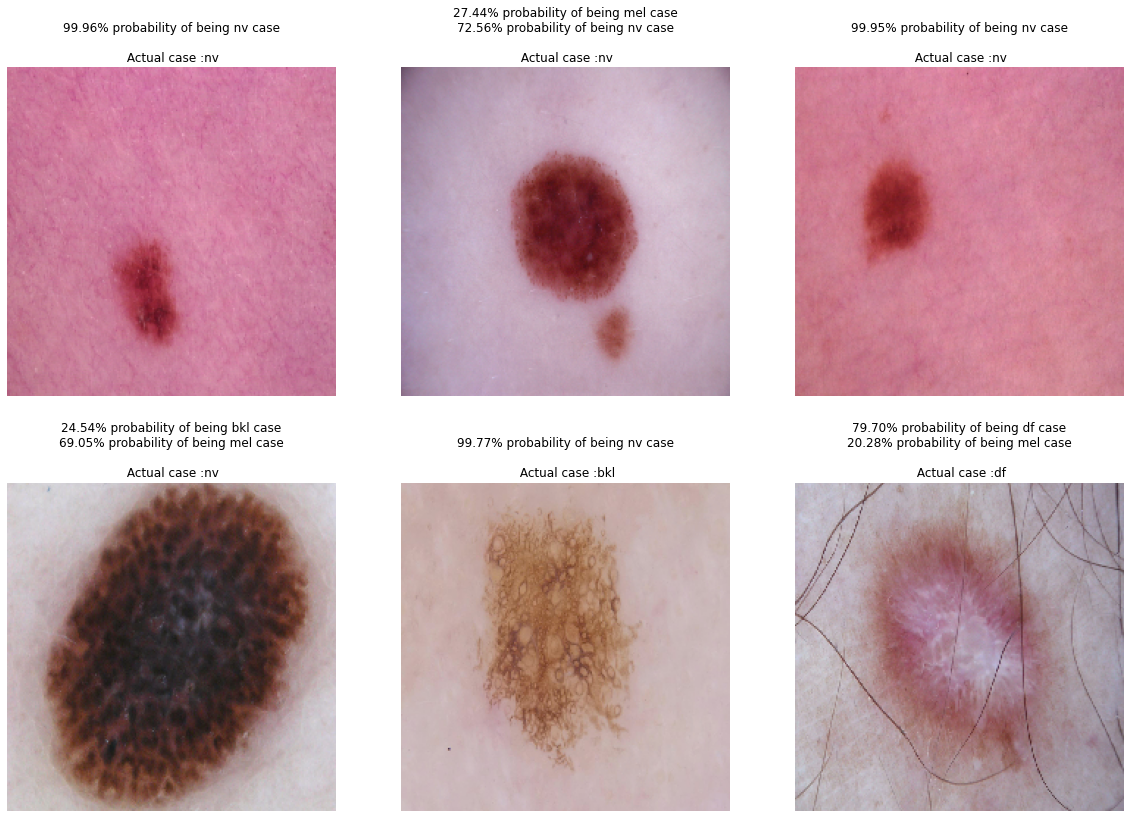

In [49]:
# ramdomly plot images in testing folder with the predicted and true case.
test_generator.reset()
x=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(x.shape)
print(y.shape)
dic = { 0 : 'akiec', 1: 'bcc', 2: 'bkl',3: 'df', 4: 'mel',5: 'nv',6: 'vasc'}
plt.figure(figsize=(20,14))

#for i in range(0+200, 9+200):
for idx, i in enumerate(np.random.randint(1, 2003, 6)):    
    plt.subplot(2, 3, idx+1)
    out = str()
    for j in range(0,6):
        if Y_pred[i][j] > 0.1:
            out += '{:.2%} probability of being {} case'.format(Y_pred[i][j], dic[j]) + '\n'
        #else: out = 'None'
      
    
    plt.title(out +"\n Actual case :" + dic[Y_true[i]])    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
plt.show()

## Conclusion

We are able to extract the information of skin cancer from the metadata and explore the distribution on varies features. The most often age of skin cancer ocur is around 45. 

We make one cnn model which can fit and predict the type of skin cancer well base on the images. The accuracy is 74.9% which is more efficient compare to detection with human eyes.
